In [1]:
import os
import pickle
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

font_path = '/Users/aghavamp/Library/Fonts/Calibri.ttf' 
fm.fontManager.addfont(font_path)
plt.rcParams.update({'font.size': 7, 'font.family':'Arial'})

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Pearson r Intrinsic

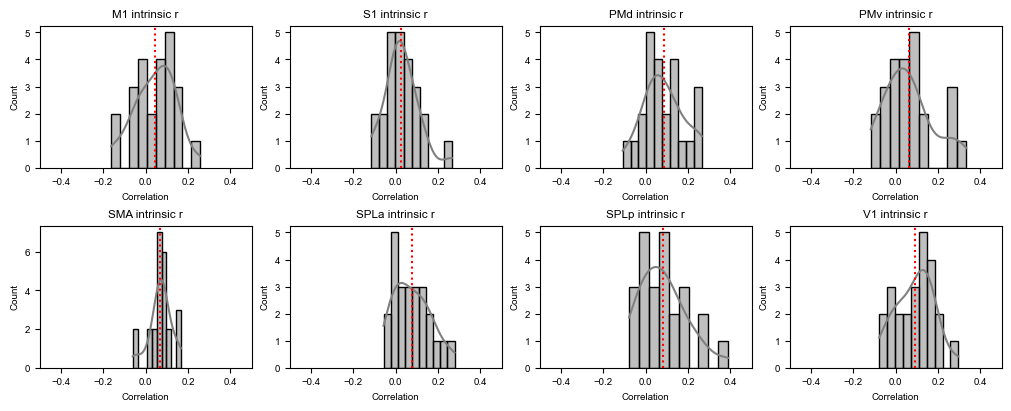

Intrinsic correlation results:
  region    mean_r    t_stat         p_unc    p_corr  reject_H0
0     M1  0.042181  2.087053  2.407876e-02  0.027519       True
1     S1  0.027154  1.622734  5.913746e-02  0.059137      False
2    PMd  0.087493  4.352397  1.169607e-04  0.000247       True
3    PMv  0.062842  2.584414  8.288852e-03  0.011052       True
4    SMA  0.069713  6.462920  6.769852e-07  0.000005       True
5   SPLa  0.077523  4.330102  1.236486e-04  0.000247       True
6   SPLp  0.082477  3.546297  8.610384e-04  0.001378       True
7     V1  0.090313  4.870651  3.215097e-05  0.000129       True


In [2]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

df = {'region':[], 'r':[], 'fisher_Z':[]}

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y']
    
    N = len(Y)
    r = []
    fisher_Z = []
    for i in range(N):
        measurements = Y[i].measurements
        cond_vec = Y[i].obs_descriptors['cond_vec']
        num_voxels = measurements.shape[1]
        ncond = 12

        # Create an array to store the averaged patterns for each condition
        averaged_patterns = np.zeros((ncond, num_voxels))

        # Loop through each condition and calculate the average pattern
        for c in range(ncond):
            # Find rows corresponding to the current condition
            condition_indices = cond_vec == c
            # Calculate the mean pattern for the current condition
            averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

        # get the contra conditions: 
        y_contra_avg = averaged_patterns[0:6, :]
        # remove mean across conditions:
        y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_contra_vec = y_contra_avg.flatten()
        
        # get the ipsi conditions:
        y_ipsi_avg = averaged_patterns[6:12, :]
        # remove mean across conditions:
        y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_ipsi_vec = y_ipsi_avg.flatten()

        # concatenate the contra and ipsi patterns:
        r.append(np.corrcoef(y_contra_vec, y_ipsi_vec)[0,1])
        fisher_Z.append(np.arctanh(r[-1]))

    r = np.array(r)
    fisher_Z = np.array(fisher_Z)
    df['region'].extend([region] * len(r))
    df['r'].extend(r)
    df['fisher_Z'].extend(fisher_Z)
    # distribution of r:
    ax = axes.flatten()[regions.index(region)]
    sns.histplot(fisher_Z, kde=True, color='gray', ax=ax, bins=10)
    ax.axvline(np.mean(fisher_Z), color='red', linestyle=':')
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Count')
    ax.set_title(f'{region} intrinsic r')
    ax.set_xlim(-0.5,0.5)
plt.show()
df = pd.DataFrame(df)

# test correation > 0:
stats_df = {'region':[], 'mean_r':[], 't_stat':[], 'p_unc':[]}
for region in regions:
    fisher_Z_region = df[df['region'] == region]['fisher_Z'].values
    t_stat, p_val = stats.ttest_1samp(fisher_Z_region, 0, alternative='greater')
    mean_r = np.tanh(np.mean(fisher_Z_region))
    stats_df['region'].append(region)
    stats_df['mean_r'].append(mean_r)
    stats_df['t_stat'].append(t_stat)
    stats_df['p_unc'].append(p_val)

# correction for multiple comparisons across regions:
from statsmodels.stats.multitest import multipletests
stats_df = pd.DataFrame(stats_df)
reject, p_corr, _, _ = multipletests(stats_df['p_unc'], alpha=0.05, method='fdr_bh')
stats_df['p_corr'] = p_corr
stats_df['reject_H0'] = reject
print('Intrinsic correlation results:')
print(stats_df)




# Pearson r Extrinsic

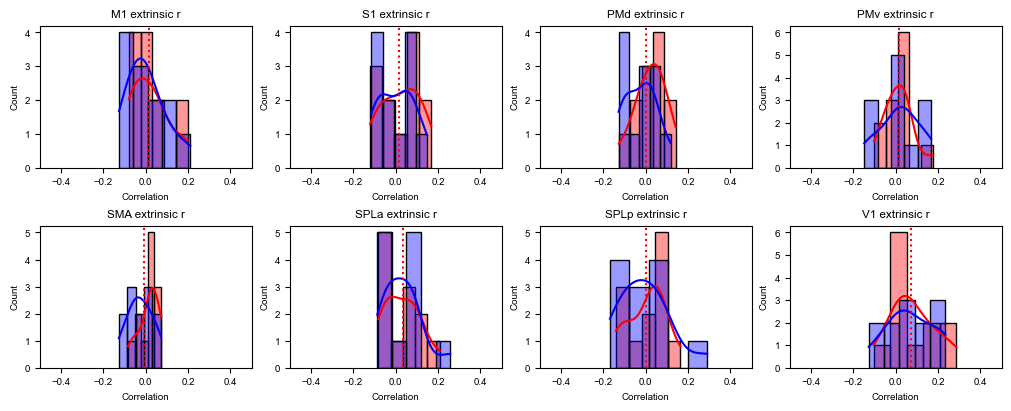

Extrinsic correlation results:
  region    mean_r    t_stat     p_unc    p_corr  reject_H0
0     M1  0.013857  0.744711  0.231994  0.371191      False
1     S1  0.013625  0.768483  0.225010  0.371191      False
2    PMd -0.000609 -0.038855  0.515329  0.588948      False
3    PMv  0.015744  0.925452  0.182170  0.371191      False
4    SMA -0.006448 -0.549820  0.706129  0.706129      False
5   SPLa  0.033330  1.882088  0.036269  0.145076      False
6   SPLp  0.001241  0.056920  0.477550  0.588948      False
7     V1  0.074435  3.329796  0.001457  0.011653       True


In [ ]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
df = {'region':[], 'r':[], 'fisher_Z':[]}

fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_extrinsic_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y']
    
    N = len(Y)
    r = []
    fisher_Z = []
    for i in range(N):
        measurements = Y[i].measurements
        cond_vec = Y[i].obs_descriptors['cond_vec']
        num_voxels = measurements.shape[1]
        ncond = 12

        # Create an array to store the averaged patterns for each condition
        averaged_patterns = np.zeros((ncond, num_voxels))

        # Loop through each condition and calculate the average pattern
        for c in range(ncond):
            # Find rows corresponding to the current condition
            condition_indices = cond_vec == c
            # Calculate the mean pattern for the current condition
            averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

        # get the contra conditions: 
        y_contra_avg = averaged_patterns[0:6, :]
        # remove mean across conditions:
        y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_contra_vec = y_contra_avg.flatten()
        
        # get the ipsi conditions:
        y_ipsi_avg = averaged_patterns[6:12, :]
        # remove mean across conditions:
        y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_ipsi_vec = y_ipsi_avg.flatten()

        # concatenate the contra and ipsi patterns:
        r.append(np.corrcoef(y_contra_vec, y_ipsi_vec)[0,1])
        fisher_Z.append(np.arctanh(r[-1]))


    r = np.array(r)
    fisher_Z = np.array(fisher_Z)
    df['region'].extend([region] * len(r))
    df['r'].extend(r)
    df['fisher_Z'].extend(fisher_Z)
    
    # distribution of r:
    ax = axes.flatten()[regions.index(region)]
    sns.histplot(fisher_Z[0:12], kde=True, color='red', alpha=0.4, ax=ax)
    sns.histplot(fisher_Z[12:24], kde=True, color='blue', alpha=0.4, ax=ax)
    ax.axvline(np.mean(fisher_Z), color='red', linestyle=':')
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Count')
    ax.set_title(f'{region} extrinsic r')
    ax.set_xlim(-0.5,0.5)
plt.show()

df = pd.DataFrame(df)

# test correation > 0:
stats_df = {'region':[], 'mean_r':[], 't_stat':[], 'p_unc':[]}
for region in regions:
    fisher_Z_region = df[df['region'] == region]['fisher_Z'].values
    t_stat, p_val = stats.ttest_1samp(fisher_Z_region, 0, alternative='greater')
    mean_r = np.tanh(np.mean(fisher_Z_region))
    stats_df['region'].append(region)
    stats_df['mean_r'].append(mean_r)
    stats_df['t_stat'].append(t_stat)
    stats_df['p_unc'].append(p_val)

# correction for multiple comparisons across regions:
from statsmodels.stats.multitest import multipletests
stats_df = pd.DataFrame(stats_df)
reject, p_corr, _, _ = multipletests(stats_df['p_unc'], alpha=0.05, method='fdr_bh')
stats_df['p_corr'] = p_corr
stats_df['reject_H0'] = reject
print('Extrinsic correlation results:')
print(stats_df)



# PCM Correlation Intrinsic

In [6]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

for region in regions:
    file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
    data = np.load(file_path)
    G_mdl = data['G_hat']
    G_mdl = G_mdl / np.trace(G_mdl)
    C = G_mdl
    within_cov = C.reshape(1,6,6)

    # setup the dataset for this analysis:
    datafile = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')
    
    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y'].tolist()

    nsteps = 200 # how many correlation models
    M = []

    # Generate the models
    for r in np.linspace(-1, 1, nsteps):
        M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=6, corr=r, cond_effect=True, within_cov=None))

    # Now make the flexible model
    Mflex = pcm.CorrelationModel("flex", num_items=6, corr=None, cond_effect=True, within_cov=None)
    M.append(Mflex)

    T, theta = pcm.fit_model_individ(Y, M, fixed_effect='block', fit_scale=False, verbose=False)

    L = T.likelihood.to_numpy()

    # express log-likelihoods relative to mean
    L = L - L.mean(axis=1).reshape(-1,1)
    maxL = L[:,-1] # Last model is the flexible
    L = L[:,0:-1] # Remove it

    # Get the correlation for each of the models
    r = np.empty((nsteps,))
    for i in range(nsteps):
        r[i]= M[i].corr

    # Get the maximum likelihood estimate of each parameter
    maxr = M[-1].get_correlation(theta[-1])
    
    # FSNR for flex model:
    theta1 = np.exp(theta[-1][2,:])
    theta2 = np.exp(theta[-1][3,:])
    theta_noise = np.exp(theta[-1][-1,:])
    fsnr = np.sqrt(theta1*theta2*10) / theta_noise

    # save results:
    outname = os.path.join(analysisDir, f'pcm_corr_unimanual_intrinsic_{region}.npz')
    np.savez(outname, r=r, L=L, maxr=maxr, maxL=maxL, fsnr=fsnr)





plot

============== M1 ==============
maxr = 0.300 +/- 0.182
============== S1 ==============
maxr = 0.316 +/- 0.180
============== PMd ==============
maxr = 0.587 +/- 0.150
============== PMv ==============
maxr = 0.346 +/- 0.173
============== SMA ==============
maxr = 0.784 +/- 0.117
============== SPLa ==============
maxr = 0.501 +/- 0.143
============== SPLp ==============
maxr = 0.499 +/- 0.154
============== V1 ==============
maxr = 0.286 +/- 0.107


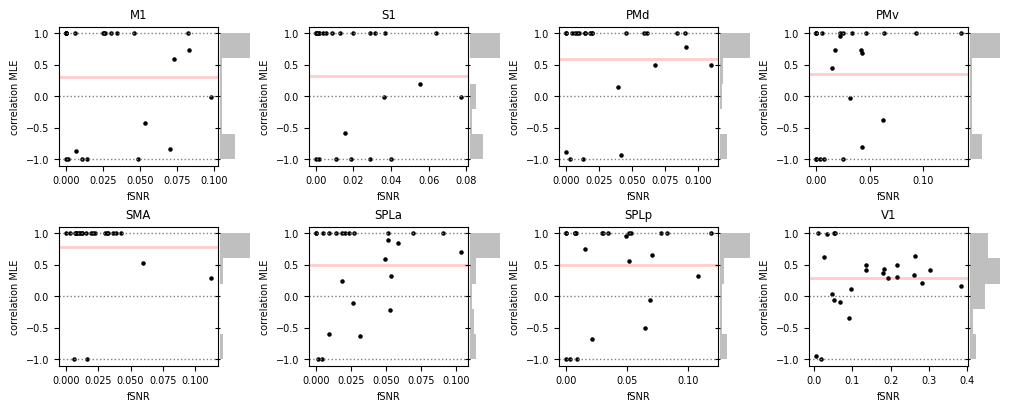

In [25]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
from mpl_toolkits.axes_grid1 import make_axes_locatable  # add this import

df = {'region':[], 'maxr':[]}

plt.rcParams.update({'font.size': 7})
# fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    # load results:
    datafile = os.path.join(analysisDir, f'pcm_corr_unimanual_intrinsic_{region}.npz')
    D = np.load(datafile, allow_pickle=True)
    r = D['r']
    L = D['L']
    maxr = D['maxr']
    df['region'].extend([region] * len(maxr))
    df['maxr'].extend(maxr)
    maxL = D['maxL']
    print(f'============== {region} ==============')
    print(f'maxr = {np.mean(maxr):.3f} +/- {stats.sem(maxr):.3f}')

    # t-test of r=1 vs 0 
    i1 = 100
    i2 = -1
    # print(f"Testing correlation of {r[i1]:0.2f} against {r[i2]:0.2f}")
    # t, p = stats.ttest_rel(L[:,i1], L[:,i2], alternative='two-sided')
    # print(f'Paired-samples t-test: t({len(L)-1})={t:1.3f}; p({len(L)-1})={p:1.6f}')

    # # t-test maxr vs 0:
    # t, p = stats.ttest_1samp(maxr, 0, alternative='two-sided')
    # print(f'One-sample t-test maxr vs 0: t({len(maxr)-1})={t:1.3f}; p={p:1.6f}')

    # Plot
    # ax = axes.flatten()[regions.index(region)]
    # ax.plot(r, L.T, color='gray', marker=None, linewidth=1)
    # ax.plot(maxr, maxL, 'k.', markersize=5)
    # ax.plot(r, L.mean(axis=0), 'k:')
    # ax.axvline(maxr.mean())
    # ax.set_xlabel('correlation')
    # ax.set_ylabel('log-likelihood')
    # ax.set_title(f'{region}')
    # ax.set_ylim((-100,60))
# plt.show()

fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    # load results:
    datafile = os.path.join(analysisDir, f'pcm_corr_unimanual_intrinsic_{region}.npz')
    D = np.load(datafile, allow_pickle=True)
    r = D['r']
    L = D['L']
    maxr = D['maxr']
    fsnr = D['fsnr']
    # Plot
    ax = axes.flatten()[regions.index(region)]
    ax.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax.axhline(1, color='gray', linestyle=':', linewidth=1)
    ax.axhline(-1, color='gray', linestyle=':', linewidth=1)
    ax.axhline(np.mean(maxr), color='red', linestyle='-', linewidth=2, alpha=0.2)
    ax.scatter(fsnr, maxr, color='k', s=5)

    # --- vertical marginal histogram of correlation MLE (maxr) ---
    divider = make_axes_locatable(ax)
    ax_marg = divider.append_axes("right", size="20%", pad=0.02, sharey=ax)
    ax_marg.hist(maxr, bins=5, orientation='horizontal', color='gray', alpha=0.5, edgecolor='none')
    # clean up marginal axis
    ax_marg.set_xticks([])
    ax_marg.set_xlabel('')
    plt.setp(ax_marg.get_yticklabels(), visible=False)
    for spine in ax_marg.spines.values():
        spine.set_visible(False)
    # -------------------------------------------------------------
    ax.set_xlabel('fSNR')
    ax.set_ylabel('correlation MLE')
    ax.set_title(f'{region}')
# plt.savefig(os.path.join('figures', 'correlation_unimanual_intrinsic_vs_fsnr.png'), dpi=300)
plt.show()



# PCM Correlation Extrinsic sorted

In [89]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

for region in regions:
    file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
    data = np.load(file_path)
    G_mdl = data['G_hat']
    G_mdl = G_mdl / np.trace(G_mdl)
    C = G_mdl
    within_cov = C.reshape(1,6,6)

    # setup the dataset for this analysis:
    datafile = os.path.join(analysisDir, f'pcm_dataset_extrinsic_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y'].tolist()

    nsteps = 200 # how many correlation models
    M = []

    # Generate the models
    for r in np.linspace(-1, 1, nsteps):
        M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=6, corr=r, cond_effect=True, within_cov=None))

    # Now make the flexible model
    Mflex = pcm.CorrelationModel("flex", num_items=6, corr=None, cond_effect=True, within_cov=None)
    M.append(Mflex)

    T, theta = pcm.fit_model_individ(Y, M, fixed_effect='block', fit_scale=False, verbose=False)

    L = T.likelihood.to_numpy()

    # express log-likelihoods relative to mean
    L = L - L.mean(axis=1).reshape(-1,1)
    maxL = L[:,-1] # Last model is the flexible
    L = L[:,0:-1] # Remove it

    # Get the correlation for each of the models
    r = np.empty((nsteps,))
    for i in range(nsteps):
        r[i]= M[i].corr

    # Get the maximum likelihood estimate of each parameter
    maxr = M[-1].get_correlation(theta[-1])

    # FSNR for flex model:
    theta1 = np.exp(theta[-1][2,:])
    theta2 = np.exp(theta[-1][3,:])
    theta_noise = np.exp(theta[-1][-1,:])
    fsnr = np.sqrt(theta1*theta2*10) / theta_noise

    # save results:
    outname = os.path.join(analysisDir, f'pcm_corr_unimanual_extrinsic_{region}.npz')
    np.savez(outname, r=r, L=L, maxr=maxr, maxL=maxL, fsnr=fsnr)



plot

============== M1 ==============
maxr = -0.034 +/- 0.180
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-1.547; p(23)=0.135631
One-sample t-test maxr vs 0: t(23)=-0.188; p=0.852642
============== S1 ==============
maxr = 0.097 +/- 0.194
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-2.171; p(23)=0.040504
One-sample t-test maxr vs 0: t(23)=0.498; p=0.622883
============== PMd ==============
maxr = 0.103 +/- 0.180
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=0.364; p(23)=0.719289
One-sample t-test maxr vs 0: t(23)=0.574; p=0.571642
============== PMv ==============
maxr = 0.197 +/- 0.181
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-0.218; p(23)=0.829008
One-sample t-test maxr vs 0: t(23)=1.086; p=0.288787
============== SMA ==============
maxr = 0.076 +/- 0.186
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=0.607; p(23)=0.549618
One-sample t-test maxr vs 0: t(23)=0.409

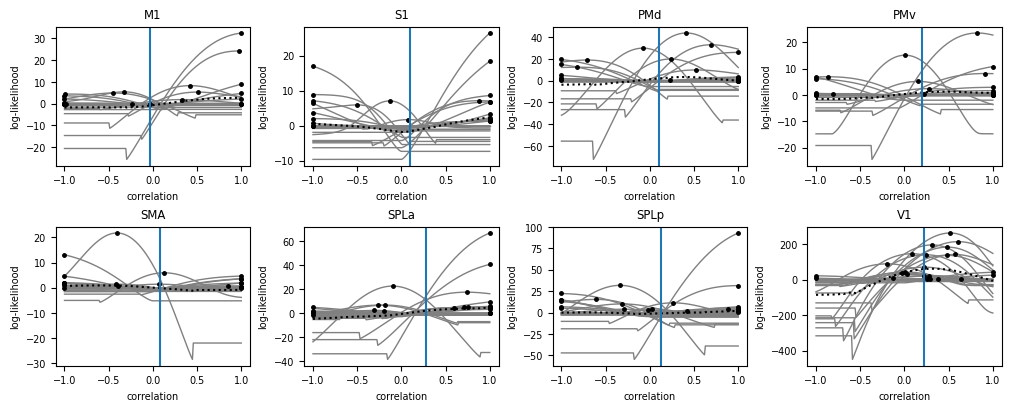

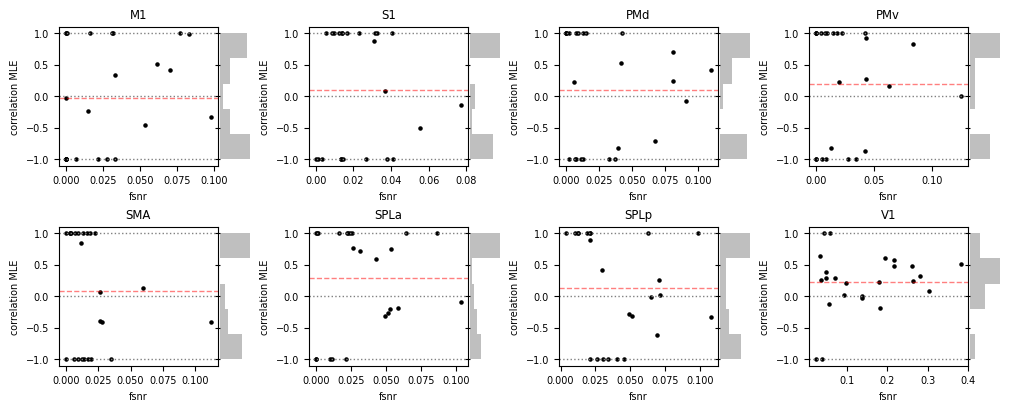

In [4]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    # load results:
    datafile = os.path.join(analysisDir, f'pcm_corr_unimanual_extrinsic_{region}.npz')
    D = np.load(datafile, allow_pickle=True)
    r = D['r']
    L = D['L']
    maxr = D['maxr']
    maxL = D['maxL']
    print(f'============== {region} ==============')
    print(f'maxr = {np.mean(maxr):.3f} +/- {stats.sem(maxr):.3f}')

    # t-test of r=1 vs 0 
    i1 = 100
    i2 = -1
    print(f"Testing correlation of {r[i1]:0.2f} against {r[i2]:0.2f}")
    t, p = stats.ttest_rel(L[:,i1], L[:,i2], alternative='two-sided')
    print(f'Paired-samples t-test: t({len(L)-1})={t:1.3f}; p({len(L)-1})={p:1.6f}')

    # t-test maxr vs 0:
    t, p = stats.ttest_1samp(maxr, 0, alternative='two-sided')
    print(f'One-sample t-test maxr vs 0: t({len(maxr)-1})={t:1.3f}; p={p:1.6f}')

    # Plot
    ax = axes.flatten()[regions.index(region)]
    ax.plot(r, L.T, color='gray', marker=None, linewidth=1)
    ax.plot(maxr, maxL, 'k.', markersize=5)
    ax.plot(r, L.mean(axis=0), 'k:')
    ax.axvline(maxr.mean())
    ax.set_xlabel('correlation')
    ax.set_ylabel('log-likelihood')
    ax.set_title(f'{region}')
plt.show()

fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    # load results:
    datafile = os.path.join(analysisDir, f'pcm_corr_unimanual_extrinsic_{region}.npz')
    D = np.load(datafile, allow_pickle=True)
    r = D['r']
    L = D['L']
    maxr = D['maxr']
    fsnr = D['fsnr']
    # Plot
    ax = axes.flatten()[regions.index(region)]
    ax.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax.axhline(1, color='gray', linestyle=':', linewidth=1)
    ax.axhline(-1, color='gray', linestyle=':', linewidth=1)
    ax.axhline(np.mean(maxr), color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.scatter(fsnr, maxr, color='k', s=5)

    # --- vertical marginal histogram of correlation MLE (maxr) ---
    divider = make_axes_locatable(ax)
    ax_marg = divider.append_axes("right", size="20%", pad=0.02, sharey=ax)
    ax_marg.hist(maxr, bins=5, orientation='horizontal', color='gray', alpha=0.5, edgecolor='none')
    # clean up marginal axis
    ax_marg.set_xticks([])
    ax_marg.set_xlabel('')
    plt.setp(ax_marg.get_yticklabels(), visible=False)
    for spine in ax_marg.spines.values():
        spine.set_visible(False)
    # -------------------------------------------------------------

    ax.set_xlabel('fsnr')
    ax.set_ylabel('correlation MLE')
    ax.set_title(f'{region}')
plt.show()




# MLE corr intrinsic and extrinsic

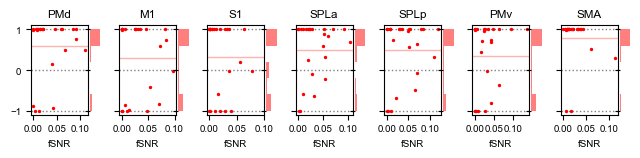

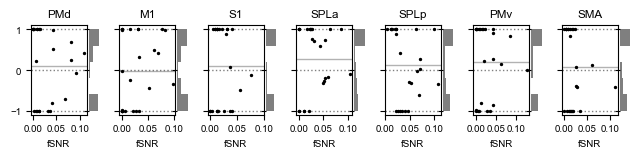

In [ ]:
regions = ['PMd','M1','S1','SPLa','SPLp','PMv','SMA']
from mpl_toolkits.axes_grid1 import make_axes_locatable  # add this import
import matplotlib.font_manager as fm

fig, axes = plt.subplots(1, 7, figsize=(6.5,1.6), sharey=True)
for region in regions:
    # load results:
    datafile_intrinsic = os.path.join(analysisDir, f'pcm_corr_unimanual_intrinsic_{region}.npz')
    datafile_extrinsic = os.path.join(analysisDir, f'pcm_corr_unimanual_extrinsic_{region}.npz')
    D_intrinsic = np.load(datafile_intrinsic, allow_pickle=True)
    D_extrinsic = np.load(datafile_extrinsic, allow_pickle=True)

    maxr_int = D_intrinsic['maxr']
    maxr_ext = D_extrinsic['maxr']
    fsnr_int = D_intrinsic['fsnr']
    fsnr_ext = D_extrinsic['fsnr']
    
    # Plot
    ax = axes.flatten()[regions.index(region)]
    ax.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax.axhline(1, color='gray', linestyle=':', linewidth=1)
    ax.axhline(-1, color='gray', linestyle=':', linewidth=1)
    ax.axhline(np.mean(maxr_int), color='red', linestyle='-', linewidth=1, alpha=0.3)
    ax.scatter(fsnr_int, maxr_int, color='red', s=2, zorder=1000)
    ax.set_xticks([0, 0.05, 0.1])

    # --- vertical marginal histogram of correlation MLE (maxr) ---
    divider = make_axes_locatable(ax)
    ax_marg = divider.append_axes("right", size="20%", pad=0.02, sharey=ax)
    ax_marg.hist(maxr_int, bins=5, orientation='horizontal', color='red', alpha=0.5, edgecolor='none')
    # clean up marginal axis
    ax_marg.set_xticks([])
    ax_marg.set_xlabel('')
    plt.setp(ax_marg.get_yticklabels(), visible=False)
    for spine in ax_marg.spines.values():
        spine.set_visible(False)
    # -------------------------------------------------------------
    ax.set_xlabel('fSNR')
    # ax.set_ylabel('correlation MLE')
    ax.set_title(f'{region}')
plt.tight_layout()
plt.savefig(os.path.join('../figures','correlation_uni', 'mle_fsnr_intrinsic.pdf'), bbox_inches="tight")
plt.show()

fig, axes = plt.subplots(1,7,figsize=(6.5,1.6),sharey=True)
for region in regions:
    # load results:
    datafile_extrinsic = os.path.join(analysisDir, f'pcm_corr_unimanual_extrinsic_{region}.npz')
    D_extrinsic = np.load(datafile_extrinsic, allow_pickle=True)

    maxr_ext = D_extrinsic['maxr']
    fsnr_ext = D_extrinsic['fsnr']

    # Plot
    ax = axes.flatten()[regions.index(region)]
    ax.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax.axhline(1, color='gray', linestyle=':', linewidth=1)
    ax.axhline(-1, color='gray', linestyle=':', linewidth=1)
    ax.axhline(np.mean(maxr_ext), color='black', linestyle='-', linewidth=1, alpha=0.3)
    ax.scatter(fsnr_ext, maxr_ext, color='black', s=2, zorder=1000)
    ax.set_xticks([0, 0.05, 0.1])

    # --- vertical marginal histogram of correlation MLE (maxr) ---
    divider = make_axes_locatable(ax)
    ax_marg = divider.append_axes("right", size="20%", pad=0.02, sharey=ax)
    ax_marg.hist(maxr_ext, bins=5, orientation='horizontal', color='black', alpha=0.5, edgecolor='none')
    # clean up marginal axis
    ax_marg.set_xticks([])
    ax_marg.set_xlabel('')
    plt.setp(ax_marg.get_yticklabels(), visible=False)
    for spine in ax_marg.spines.values():
        spine.set_visible(False)
    # -------------------------------------------------------------
    ax.set_xlabel('fSNR')
    # ax.set_ylabel('correlation MLE')
    ax.set_title(f'{region}')
plt.tight_layout()
plt.savefig(os.path.join('../figures','correlation_uni', 'mle_fsnr_extrinsic.pdf'), bbox_inches="tight")
plt.show()



# Pearson r Intrinsic confidence interval

In [33]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

def bootstrap_roi_correlation(condA, condB, m=200, B=2000, rng=None):
    """
    condA, condB: 1D arrays of length V (voxels) with condition pattern values (e.g., beta estimates)
    m: subset size of voxels to sample with replacement each bootstrap
    B: number of bootstrap replicates
    Returns:
      z_bar: mean Fisher-z across replicates (per-hemisphere estimator for group level)
      r_ci: 95% CI on r from bootstrap percentiles (optional descriptive)
      r_dist: array of bootstrap r values (for diagnostics)
    """
    assert condA.shape == condB.shape
    V = condA.size
    if rng is None:
        # choose a random number generator
        rng = np.random.default_rng()
    # bootstrap:
    r_vals = np.empty(B, dtype=float)
    vox = np.arange(V)
    for b in range(B):
        idx = rng.choice(vox, size=m, replace=True)
        a = condA[idx]
        c = condB[idx]
        # demean to mitigate mean shifts across conditions
        a = a - a.mean()
        c = c - c.mean()
        num = np.dot(a, c)
        den = np.linalg.norm(a) * np.linalg.norm(c)
        r = num / den if den > 0 else 0.0
        r_vals[b] = np.clip(r, -0.999999, 0.999999)
    z_vals = np.arctanh(r_vals)
    z_bar = np.nanmean(z_vals)
    # Descriptive 95% CI on r via percentile in z-space then back-transform
    z_lo, z_hi = np.nanpercentile(z_vals, [2.5, 97.5])
    r_ci = (np.tanh(z_lo), np.tanh(z_hi))
    return z_bar, r_ci, r_vals

for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    n_data = len(D['Y'])
    
    # for h in ['L', 'R']:
    #     if h == 'L':
    #         Y = D['Y'][:n_data//2]
    #     else:
    #         Y = D['Y'][n_data//2:]
    Y = D['Y']
    N = len(Y)
    r = []
    z_scores = []
    for i in range(N):
        measurements = Y[i].measurements
        cond_vec = Y[i].obs_descriptors['cond_vec']
        num_voxels = measurements.shape[1]
        ncond = 12

        # Create an array to store the averaged patterns for each condition
        averaged_patterns = np.zeros((ncond, num_voxels))
        
        # Loop through each condition and calculate the average pattern
        for c in range(ncond):
            # Find rows corresponding to the current condition
            condition_indices = cond_vec == c
            # Calculate the mean pattern for the current condition
            averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

        # get the contra conditions: 
        y_contra_avg = averaged_patterns[0:6, :]
        # remove mean across conditions:
        y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_contra_vec = y_contra_avg.flatten()
        
        # get the ipsi conditions:
        y_ipsi_avg = averaged_patterns[6:12, :]
        # remove mean across conditions:
        y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_ipsi_vec = y_ipsi_avg.flatten()

        z_bar, r_ci, r_dist = bootstrap_roi_correlation(y_contra_vec, y_ipsi_vec, m=200, B=2000, rng=None)
        r.append(np.tanh(z_bar))
        z_scores.append(z_bar)

    z_scores = np.array(z_scores)
    # Calculate Group Mean and CI in Z-space
    z_mean = np.mean(z_scores)
    z_se = stats.sem(z_scores)

    # Calculate 95% CI using t-distribution:
    alpha = 0.95
    df = len(z_scores) - 1
    t_val = stats.t.ppf((1 + alpha) / 2, df)
    ci_lo_z = z_mean - t_val * z_se
    ci_hi_z = z_mean + t_val * z_se

    # Transform back to r-space
    r_mean_group = np.tanh(z_mean)
    ci_lo_r = np.tanh(ci_lo_z)
    ci_hi_r = np.tanh(ci_hi_z)

    t_stat, p_val = stats.ttest_1samp(z_scores, popmean=0)
    
    print(f'============== {region} ==============')
    print(f'Mean r: {r_mean_group:.3f} (95% CI: {ci_lo_r:.3f} to {ci_hi_r:.3f})')
    print(f't({df}) = {t_stat:.2f}, p {p_val:.7e}\n')



============== M1 ==============
Mean r: 0.043 (95% CI: 0.001 to 0.085)
t(23) = 2.12, p 4.4915834e-02

============== S1 ==============
Mean r: 0.027 (95% CI: -0.008 to 0.062)
t(23) = 1.61, p 1.2029947e-01

============== PMd ==============
Mean r: 0.087 (95% CI: 0.046 to 0.129)
t(23) = 4.36, p 2.2897711e-04

============== PMv ==============
Mean r: 0.063 (95% CI: 0.013 to 0.113)
t(23) = 2.58, p 1.6559241e-02

============== SMA ==============
Mean r: 0.070 (95% CI: 0.047 to 0.092)
t(23) = 6.46, p 1.3781478e-06

============== SPLa ==============
Mean r: 0.077 (95% CI: 0.040 to 0.114)
t(23) = 4.32, p 2.5224427e-04

============== SPLp ==============
Mean r: 0.082 (95% CI: 0.034 to 0.130)
t(23) = 3.50, p 1.9194697e-03

============== V1 ==============
Mean r: 0.090 (95% CI: 0.052 to 0.128)
t(23) = 4.83, p 7.0594973e-05



# Pearson r Extrinsic bootstrap 

In [41]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

def bootstrap_roi_correlation(condA, condB, m=200, B=2000, rng=None):
    """
    condA, condB: 1D arrays of length V (voxels) with condition pattern values (e.g., beta estimates)
    m: subset size of voxels to sample with replacement each bootstrap
    B: number of bootstrap replicates
    Returns:
      z_bar: mean Fisher-z across replicates (per-hemisphere estimator for group level)
      r_ci: 95% CI on r from bootstrap percentiles (optional descriptive)
      r_dist: array of bootstrap r values (for diagnostics)
    """
    assert condA.shape == condB.shape
    V = condA.size
    if rng is None:
        rng = np.random.default_rng()
    r_vals = np.empty(B, dtype=float)
    vox = np.arange(V)
    for b in range(B):
        idx = rng.choice(vox, size=m, replace=True)
        a = condA[idx]
        c = condB[idx]
        # demean to mitigate mean shifts across conditions
        a = a - a.mean()
        c = c - c.mean()
        num = np.dot(a, c)
        den = np.linalg.norm(a) * np.linalg.norm(c)
        r = num / den if den > 0 else 0.0
        r_vals[b] = np.clip(r, -0.999999, 0.999999)
    z_vals = np.arctanh(r_vals)
    z_bar = np.nanmean(z_vals)
    # Descriptive 95% CI on r via percentile in z-space then back-transform
    z_lo, z_hi = np.nanpercentile(z_vals, [2.5, 97.5])
    r_ci = (np.tanh(z_lo), np.tanh(z_hi))
    return z_bar, r_ci, r_vals

for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_extrinsic_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    n_data = len(D['Y'])
    
    # for h in ['L', 'R']:
    #     if h == 'L':
    #         Y = D['Y'][:n_data//2]
    #     else:
    #         Y = D['Y'][n_data//2:]
    Y = D['Y']
    N = len(Y)
    r = []
    z_scores = []
    for i in range(N):
        measurements = Y[i].measurements
        cond_vec = Y[i].obs_descriptors['cond_vec']
        num_voxels = measurements.shape[1]
        ncond = 12

        # Create an array to store the averaged patterns for each condition
        averaged_patterns = np.zeros((ncond, num_voxels))
        
        # Loop through each condition and calculate the average pattern
        for c in range(ncond):
            # Find rows corresponding to the current condition
            condition_indices = cond_vec == c
            # Calculate the mean pattern for the current condition
            averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

        # get the contra conditions: 
        y_contra_avg = averaged_patterns[0:6, :]
        # remove mean across conditions:
        y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_contra_vec = y_contra_avg.flatten()
        
        # get the ipsi conditions:
        y_ipsi_avg = averaged_patterns[6:12, :]
        # remove mean across conditions:
        y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_ipsi_vec = y_ipsi_avg.flatten()

        z_bar, r_ci, r_dist = bootstrap_roi_correlation(y_contra_vec, y_ipsi_vec, m=200, B=2000, rng=None)
        r.append(np.tanh(z_bar))
        z_scores.append(z_bar)
    
    r = np.array(r)
    z_scores = np.array(z_scores)
    # Calculate Group Mean and CI in Z-space
    z_mean = np.mean(z_scores)
    z_se = stats.sem(z_scores)

    # Calculate 95% CI using t-distribution:
    alpha = 0.95
    df = len(z_scores) - 1
    t_val = stats.t.ppf((1 + alpha) / 2, df)
    ci_lo_z = z_mean - t_val * z_se
    ci_hi_z = z_mean + t_val * z_se

    # Transform back to r-space
    r_mean_group = np.tanh(z_mean)
    ci_lo_r = np.tanh(ci_lo_z)
    ci_hi_r = np.tanh(ci_hi_z)

    t_stat, p_val = stats.ttest_1samp(r, popmean=0)
    
    print(f'============== {region} ==============')
    print(f'Mean r: {r_mean_group:.3f} (95% CI: {ci_lo_r:.3f} to {ci_hi_r:.3f})')
    print(f't({df}) = {t_stat:.2f}, p {p_val:.7e}\n')

for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_extrinsic_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    n_data = len(D['Y'])
    
    for h in ['L', 'R']:
        if h == 'L':
            Y = D['Y'][:n_data//2]
        else:
            Y = D['Y'][n_data//2:]
    
        N = len(Y)
        r = []
        z_scores = []
        for i in range(N):
            measurements = Y[i].measurements
            cond_vec = Y[i].obs_descriptors['cond_vec']
            num_voxels = measurements.shape[1]
            ncond = 12
            
            # Create an array to store the averaged patterns for each condition
            averaged_patterns = np.zeros((ncond, num_voxels))
            
            # Loop through each condition and calculate the average pattern
            for c in range(ncond):
                # Find rows corresponding to the current condition
                condition_indices = cond_vec == c
                # Calculate the mean pattern for the current condition
                averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

            # get the contra conditions: 
            y_contra_avg = averaged_patterns[0:6, :]
            # remove mean across conditions:
            y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
            # flatten the averaged patterns:
            y_contra_vec = y_contra_avg.flatten()
            
            # get the ipsi conditions:
            y_ipsi_avg = averaged_patterns[6:12, :]
            # remove mean across conditions:
            y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
            # flatten the averaged patterns:
            y_ipsi_vec = y_ipsi_avg.flatten()

            z_bar, r_ci, r_dist = bootstrap_roi_correlation(y_contra_vec, y_ipsi_vec, m=200, B=2000, rng=None)
            r.append(np.tanh(z_bar))
            z_scores.append(z_bar)

        z_scores = np.array(z_scores)
        # Calculate Group Mean and CI in Z-space
        z_mean = np.mean(z_scores)
        z_se = stats.sem(z_scores)

        # Calculate 95% CI using t-distribution:
        alpha = 0.95
        df = len(z_scores) - 1
        t_val = stats.t.ppf((1 + alpha) / 2, df)
        ci_lo_z = z_mean - t_val * z_se
        ci_hi_z = z_mean + t_val * z_se

        # Transform back to r-space
        r_mean_group = np.tanh(z_mean)
        ci_lo_r = np.tanh(ci_lo_z) 
        ci_hi_r = np.tanh(ci_hi_z)

        t_stat, p_val = stats.ttest_1samp(z_scores, popmean=0)
        
        print(f'============== {region} {h} ==============')
        print(f'Mean r: {r_mean_group:.3f} (95% CI: {ci_lo_r:.3f} to {ci_hi_r:.3f})')
        print(f't({df}) = {t_stat:.2f}, p {p_val:.7e}\n')



============== M1 ==============
Mean r: 0.014 (95% CI: -0.024 to 0.052)
t(23) = 0.74, p 4.6609261e-01

============== S1 ==============
Mean r: 0.014 (95% CI: -0.023 to 0.050)
t(23) = 0.76, p 4.5324439e-01

============== PMd ==============
Mean r: -0.000 (95% CI: -0.033 to 0.032)
t(23) = -0.01, p 9.9186392e-01

============== PMv ==============
Mean r: 0.016 (95% CI: -0.019 to 0.051)
t(23) = 0.95, p 3.5250749e-01

============== SMA ==============
Mean r: -0.007 (95% CI: -0.031 to 0.017)
t(23) = -0.59, p 5.5955824e-01

============== SPLa ==============
Mean r: 0.034 (95% CI: -0.003 to 0.070)
t(23) = 1.89, p 7.1674982e-02

============== SPLp ==============
Mean r: 0.001 (95% CI: -0.044 to 0.046)
t(23) = 0.04, p 9.6597639e-01

============== V1 ==============
Mean r: 0.074 (95% CI: 0.028 to 0.120)
t(23) = 3.32, p 2.9947972e-03

============== M1 L ==============
Mean r: 0.023 (95% CI: -0.034 to 0.080)
t(11) = 0.90, p 3.8536618e-01

============== M1 R ==============
Mean r: 0.005 (95